In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from h5py import File
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader, Subset
from vis_utils import plot_time_series
import numpy as np

In [23]:
# read the first 500 stimulus values with responses
# we are working only with the first channel
file_path = "../data/neural_code_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5"
with File(file_path, 'r') as file:
    x = np.asarray(file["train"]["stimulus"][:500])
    y = np.asarray(file["train"]["response"]["firing_rate_10ms"][0][:500])

In [24]:
print("Stimulus shape:", x.shape)
print("Response shape:", y.shape)

Stimulus shape: (500, 50, 50)
Response shape: (500,)


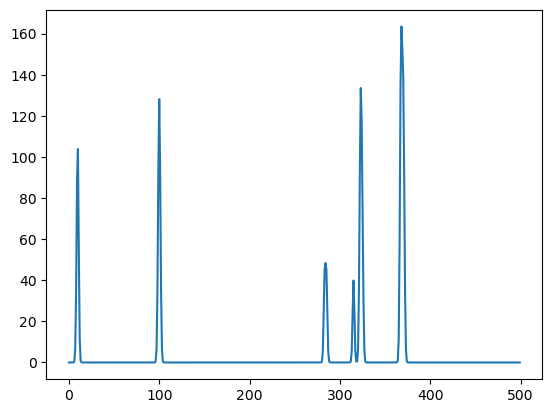

In [25]:
# plot response
plt.plot(y)

In [26]:
def create_bool_mask(arr):
    # Initialize the mask with False values
    mask = np.zeros_like(arr, dtype=bool)
    
    # Iterate through the array to find elements greater than 0
    for i in range(len(arr)):
        if arr[i] > 0:
            # Calculate the start and end indices for the neighborhood
            start = max(0, i - 10)
            end = min(len(arr), i + 10 + 1)
            # Set the neighborhood values in the mask to True
            mask[start:end] = True
            
    return mask

In [27]:
mask = create_bool_mask(y)

In [28]:
# from x,y take only the values where the mask is True
x_masked = x[mask]
y_masked = y[mask]

print("Stimulus shape after masking:", x_masked.shape)
print("Response shape after masking:", y_masked.shape)

Stimulus shape after masking: (163, 50, 50)
Response shape after masking: (163,)


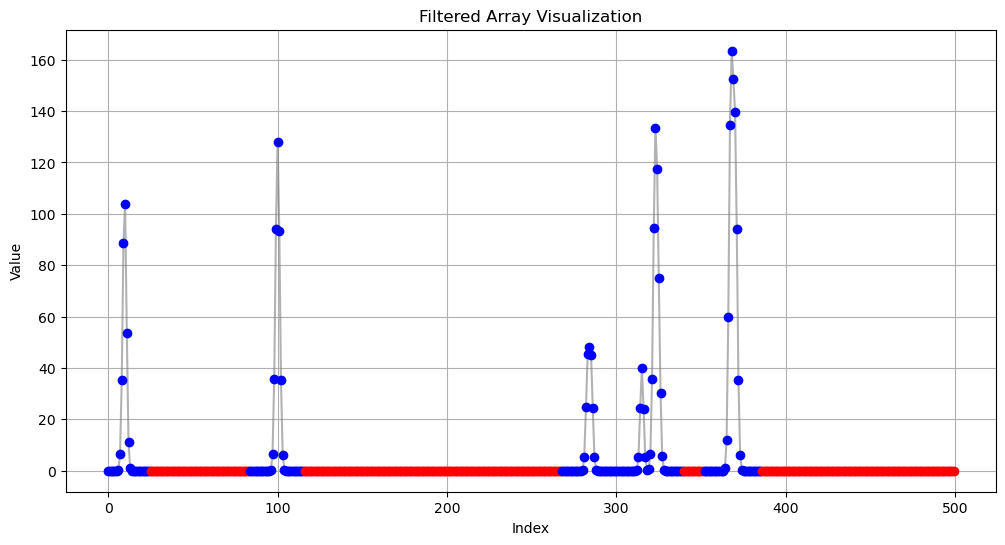

In [29]:
def plot_filtered_array(arr):
    mask = create_bool_mask(arr)
    plt.figure(figsize=(12, 6))
    plt.plot(arr, label='Original Array', color='grey', alpha=0.6)
    # Plot the filtered areas (in blue) and removed areas (in red)
    for i in range(len(arr)):
        if mask[i]:
            plt.plot(i, arr[i], 'bo')
        else:
            plt.plot(i, arr[i], 'ro')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Filtered Array Visualization')
    plt.grid(True)
    plt.show()

plot_filtered_array(y)

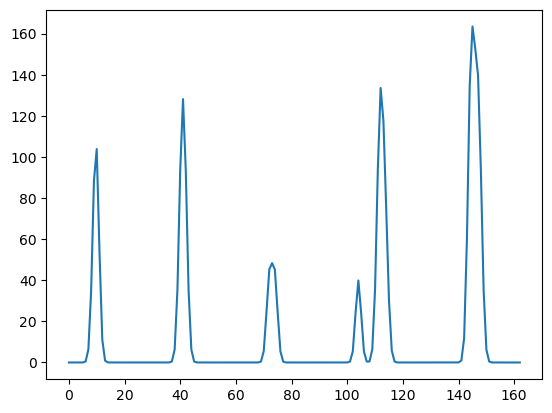

In [9]:
plt.plot(y_masked)

# Datasets, Dataloaders #

In [44]:
# define the transform function
trans = transforms.Compose([
    transforms.ToTensor(),
])

In [89]:
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, images: np.array,
                 responses: np.array,
                 sequence_length: int = 10,
                 transform: transforms.Compose = trans,
                 ):
        self.X = images
        self.y = responses
        self.transform = transform

        self.sequence_length = sequence_length
        self.dataset_len = len(images)

    def __getitem__(self, idx: int):
        # Handle wrapping around the dataset for indices less than sequence length
        if idx < self.sequence_length - 1:
            wrapped_indices = [(idx - i) % self.dataset_len for i in range(self.sequence_length)]
            wrapped_indices = wrapped_indices[::-1]  # Reverse to maintain the correct order
        else:
            wrapped_indices = list(range(idx - self.sequence_length + 1, idx + 1))

        # Get the sequence of images
        x_sequence = self.X[wrapped_indices]
        
        # Transform each image in the sequence if a transform is provided
        if self.transform:
            x_sequence = np.array([self.transform(img) for img in x_sequence])
        x_sequence = torch.tensor(x_sequence, dtype=torch.float32)
        x_sequence = x_sequence.squeeze(1)
        # Get the response of the last image in the sequence
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x_sequence, y

    def __len__(self):
        return self.dataset_len

In [142]:
train_dataset = H5Dataset(x_masked, y_masked, sequence_length=5)
val_dataset = H5Dataset(x_masked, y_masked, sequence_length=5)
test_dataset = H5Dataset(x_masked, y_masked, sequence_length=5)

In [143]:
# create data loaders
BATCH_SIZE = len(x_masked)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Classic CNN from the previous milestone #

In [92]:
class RetinaCNN(nn.Module):
    def __init__(self, 
                 out_channels: int = 8,
                 n_units: int = 9):
        super(RetinaCNN, self).__init__()
        self.out_channels = out_channels
        self.n_units = n_units
        # some hyperparameters from the original repo
        self.bn_moment = 0.1
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels= 2 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2 * out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        self.conv3 = nn.Conv2d(in_channels=2 * out_channels, out_channels= 4 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(4 * out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        # Fully connected layer
        self.fc = nn.Linear(50 * 50 * 4 * out_channels, self.n_units, bias=True)
        # self.bn4 = nn.BatchNorm1d(self.n_units, eps=1e-3,
        #                                  momentum=self.bn_moment)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch
        # Forward pass through the fully connected layer to predict ganglion cell responses
        x = self.fc(x)
        # x = self.bn4(x)
        x = self.softplus(x)
        return x

model = RetinaCNN(n_units=1)

# CNN+RNN model 

In [151]:
class RetinaCNN(nn.Module):
    def __init__(self, 
                 out_channels: int = 8,
                 n_units: int = 9):
        super(RetinaCNN, self).__init__()
        self.out_channels = out_channels
        self.n_units = n_units
        self.bn_moment = 0.1

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3, momentum=self.bn_moment)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=2 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2 * out_channels, eps=1e-3, momentum=self.bn_moment)
        # self.conv3 = nn.Conv2d(in_channels=2 * out_channels, out_channels=4 * out_channels, kernel_size=3, stride=1, padding=1)
        # self.bn3 = nn.BatchNorm2d(4 * out_channels, eps=1e-3, momentum=self.bn_moment)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        
        # x = self.conv3(x)
        # x = self.bn3(x)
        # x = nn.ReLU()(x)
        
        x = nn.Flatten()(x)
        return x

class CNNRNNModel(nn.Module):
    def __init__(self, image_shape, out_channels: int = 8, n_units: int = 9):
        super(CNNRNNModel, self).__init__()

        # Define the CNN part using RetinaCNN
        self.cnn = RetinaCNN(out_channels, n_units)

        # Calculate the size of the feature map after the CNN layers
        with torch.no_grad():
            self.feature_size = self.cnn(torch.zeros(1, *image_shape)).shape[1]

        # Define the RNN part
        self.rnn = nn.LSTM(input_size=self.feature_size, hidden_size=512, batch_first=True)
        self.fc = nn.Linear(512, n_units)

    def forward(self, x):
        cnn_out = self.cnn(x)
        rnn_out, _ = self.rnn(cnn_out)
        output = self.fc(rnn_out)
        output = nn.Softplus()(output)
        return output

In [156]:
model = CNNRNNModel(image_shape=(5,50,50), n_units=1)

In [157]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=1.0):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        weights = torch.where(targets > 1, self.weight, 1.0)
        return torch.mean(weights * (inputs - targets) ** 2)

In [158]:
# define training parameters
LEARNING_RATE = 0.005
EPOCHS = 70
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = WeightedMSELoss(weight=10)

In [159]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()
# model.train()

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader, desc='Training Batches', leave=False):
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in val_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), '../models/best_model_filtered.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    # print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss}')


    torch.save(model.state_dict(), '../models/final_model_filtered.pth')

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 13314.5673828125 		 Validation Loss: 12032.4990234375


  1%|▏         | 1/70 [00:00<00:41,  1.65it/s]

Epoch 2 		 Training Loss: 12034.1005859375 		 Validation Loss: 11713.5029296875


  3%|▎         | 2/70 [00:01<00:55,  1.22it/s]

Epoch 3 		 Training Loss: 11714.833984375 		 Validation Loss: 11449.6474609375


  4%|▍         | 3/70 [00:02<00:48,  1.38it/s]

Epoch 4 		 Training Loss: 11436.75390625 		 Validation Loss: 11174.4853515625


  6%|▌         | 4/70 [00:02<00:45,  1.45it/s]

Epoch 5 		 Training Loss: 11168.755859375 		 Validation Loss: 10906.9189453125


  7%|▋         | 5/70 [00:03<00:43,  1.50it/s]

Epoch 6 		 Training Loss: 10891.4443359375 		 Validation Loss: 10653.5537109375


  9%|▊         | 6/70 [00:04<00:42,  1.52it/s]

Epoch 7 		 Training Loss: 10640.0634765625 		 Validation Loss: 10407.6318359375


 10%|█         | 7/70 [00:04<00:40,  1.54it/s]

Epoch 8 		 Training Loss: 10386.1650390625 		 Validation Loss: 10174.076171875


 11%|█▏        | 8/70 [00:05<00:40,  1.54it/s]

Epoch 9 		 Training Loss: 10144.3759765625 		 Validation Loss: 9944.1552734375


 13%|█▎        | 9/70 [00:06<00:39,  1.53it/s]

Epoch 10 		 Training Loss: 9893.998046875 		 Validation Loss: 9724.759765625


 14%|█▍        | 10/70 [00:06<00:39,  1.52it/s]

Epoch 11 		 Training Loss: 9647.8583984375 		 Validation Loss: 9466.447265625


 16%|█▌        | 11/70 [00:07<00:38,  1.52it/s]

Epoch 12 		 Training Loss: 9414.5771484375 		 Validation Loss: 9219.3427734375


 17%|█▋        | 12/70 [00:08<00:37,  1.53it/s]

Epoch 13 		 Training Loss: 9163.0078125 		 Validation Loss: 8984.556640625


 19%|█▊        | 13/70 [00:08<00:37,  1.54it/s]

Epoch 14 		 Training Loss: 8937.0966796875 		 Validation Loss: 8748.841796875


 20%|██        | 14/70 [00:09<00:36,  1.55it/s]

Epoch 15 		 Training Loss: 8675.6513671875 		 Validation Loss: 8525.263671875


 21%|██▏       | 15/70 [00:09<00:35,  1.55it/s]

Epoch 16 		 Training Loss: 8459.7734375 		 Validation Loss: 8346.7177734375


 23%|██▎       | 16/70 [00:10<00:34,  1.56it/s]

Epoch 17 		 Training Loss: 8275.7021484375 		 Validation Loss: 8183.9111328125


 24%|██▍       | 17/70 [00:11<00:36,  1.46it/s]

Epoch 18 		 Training Loss: 8121.33642578125 		 Validation Loss: 8037.8740234375


 26%|██▌       | 18/70 [00:11<00:34,  1.49it/s]

Epoch 19 		 Training Loss: 8001.7802734375 		 Validation Loss: 7921.6357421875


 27%|██▋       | 19/70 [00:12<00:33,  1.51it/s]

Epoch 20 		 Training Loss: 7899.92919921875 		 Validation Loss: 7821.8681640625


 29%|██▊       | 20/70 [00:13<00:32,  1.53it/s]

Epoch 21 		 Training Loss: 7809.90234375 		 Validation Loss: 7739.1005859375


 30%|███       | 21/70 [00:13<00:31,  1.55it/s]

Epoch 22 		 Training Loss: 7730.62353515625 		 Validation Loss: 7671.32958984375


 31%|███▏      | 22/70 [00:14<00:30,  1.55it/s]

Epoch 23 		 Training Loss: 7670.9619140625 		 Validation Loss: 7624.212890625


 33%|███▎      | 23/70 [00:15<00:30,  1.56it/s]

Epoch 24 		 Training Loss: 7625.16015625 		 Validation Loss: 7590.4951171875


 34%|███▍      | 24/70 [00:15<00:30,  1.53it/s]

Epoch 25 		 Training Loss: 7591.8828125 		 Validation Loss: 7566.94921875


 36%|███▌      | 25/70 [00:16<00:29,  1.54it/s]

Epoch 26 		 Training Loss: 7568.06982421875 		 Validation Loss: 7551.60107421875


 37%|███▋      | 26/70 [00:17<00:28,  1.55it/s]

Epoch 27 		 Training Loss: 7552.24072265625 		 Validation Loss: 7542.91015625


 39%|███▊      | 27/70 [00:17<00:28,  1.51it/s]

Epoch 28 		 Training Loss: 7543.15234375 		 Validation Loss: 7539.54736328125


 40%|████      | 28/70 [00:18<00:27,  1.51it/s]

Epoch 29 		 Training Loss: 7539.6611328125 		 Validation Loss: 7540.55810546875


 41%|████▏     | 29/70 [00:18<00:24,  1.70it/s]

Epoch 30 		 Training Loss: 7540.51611328125 		 Validation Loss: 7544.67236328125


 43%|████▎     | 30/70 [00:19<00:21,  1.90it/s]

Epoch 31 		 Training Loss: 7544.564453125 		 Validation Loss: 7550.900390625


 44%|████▍     | 31/70 [00:19<00:18,  2.07it/s]

Epoch 32 		 Training Loss: 7550.7783203125 		 Validation Loss: 7558.36572265625


 46%|████▌     | 32/70 [00:20<00:17,  2.20it/s]

Epoch 33 		 Training Loss: 7558.29833984375 		 Validation Loss: 7566.43701171875


 47%|████▋     | 33/70 [00:20<00:16,  2.23it/s]

Epoch 34 		 Training Loss: 7566.2001953125 		 Validation Loss: 7574.2744140625


 49%|████▊     | 34/70 [00:20<00:15,  2.30it/s]

Epoch 35 		 Training Loss: 7574.0244140625 		 Validation Loss: 7581.435546875


 50%|█████     | 35/70 [00:21<00:14,  2.35it/s]

Epoch 36 		 Training Loss: 7581.1552734375 		 Validation Loss: 7587.44677734375


 51%|█████▏    | 36/70 [00:21<00:14,  2.36it/s]

Epoch 37 		 Training Loss: 7586.60009765625 		 Validation Loss: 7592.2470703125


 53%|█████▎    | 37/70 [00:22<00:13,  2.37it/s]

Epoch 38 		 Training Loss: 7591.11572265625 		 Validation Loss: 7594.86474609375


 54%|█████▍    | 38/70 [00:22<00:13,  2.43it/s]

Epoch 39 		 Training Loss: 7593.86181640625 		 Validation Loss: 7596.35595703125


 56%|█████▌    | 39/70 [00:22<00:12,  2.43it/s]

Epoch 40 		 Training Loss: 7595.18896484375 		 Validation Loss: 7596.107421875


 57%|█████▋    | 40/70 [00:23<00:12,  2.47it/s]

Epoch 41 		 Training Loss: 7594.703125 		 Validation Loss: 7594.8505859375


 59%|█████▊    | 41/70 [00:23<00:11,  2.50it/s]

Epoch 42 		 Training Loss: 7593.201171875 		 Validation Loss: 7591.57470703125


 60%|██████    | 42/70 [00:24<00:11,  2.52it/s]

Epoch 43 		 Training Loss: 7590.53369140625 		 Validation Loss: 7585.419921875


 61%|██████▏   | 43/70 [00:24<00:10,  2.46it/s]

Epoch 44 		 Training Loss: 7585.50048828125 		 Validation Loss: 7581.84423828125


 63%|██████▎   | 44/70 [00:24<00:10,  2.50it/s]

Epoch 45 		 Training Loss: 7581.63232421875 		 Validation Loss: 7577.70849609375


 64%|██████▍   | 45/70 [00:25<00:10,  2.41it/s]

Epoch 46 		 Training Loss: 7577.5537109375 		 Validation Loss: 7573.2802734375


 66%|██████▌   | 46/70 [00:25<00:10,  2.36it/s]

Epoch 47 		 Training Loss: 7573.34912109375 		 Validation Loss: 7568.95458984375


 67%|██████▋   | 47/70 [00:26<00:09,  2.42it/s]

Epoch 48 		 Training Loss: 7568.9609375 		 Validation Loss: 7564.42529296875


 69%|██████▊   | 48/70 [00:26<00:09,  2.36it/s]

Epoch 49 		 Training Loss: 7564.5693359375 		 Validation Loss: 7559.46728515625


 70%|███████   | 49/70 [00:27<00:08,  2.45it/s]

Epoch 50 		 Training Loss: 7559.69091796875 		 Validation Loss: 7554.736328125


 71%|███████▏  | 50/70 [00:27<00:07,  2.52it/s]

Epoch 51 		 Training Loss: 7555.06884765625 		 Validation Loss: 7550.931640625


 73%|███████▎  | 51/70 [00:27<00:07,  2.58it/s]

Epoch 52 		 Training Loss: 7551.146484375 		 Validation Loss: 7547.83251953125


 74%|███████▍  | 52/70 [00:28<00:07,  2.52it/s]

Epoch 53 		 Training Loss: 7547.94580078125 		 Validation Loss: 7545.12939453125


 76%|███████▌  | 53/70 [00:28<00:06,  2.57it/s]

Epoch 54 		 Training Loss: 7545.28759765625 		 Validation Loss: 7543.189453125


 77%|███████▋  | 54/70 [00:28<00:06,  2.52it/s]

Epoch 55 		 Training Loss: 7543.18408203125 		 Validation Loss: 7541.61181640625


 79%|███████▊  | 55/70 [00:29<00:05,  2.54it/s]

Epoch 56 		 Training Loss: 7541.7841796875 		 Validation Loss: 7540.55908203125


 80%|████████  | 56/70 [00:29<00:05,  2.57it/s]

Epoch 57 		 Training Loss: 7540.7412109375 		 Validation Loss: 7539.85888671875


 81%|████████▏ | 57/70 [00:30<00:05,  2.58it/s]

Epoch 58 		 Training Loss: 7540.03271484375 		 Validation Loss: 7539.515625


 83%|████████▎ | 58/70 [00:30<00:05,  2.13it/s]

Epoch 59 		 Training Loss: 7539.5751953125 		 Validation Loss: 7539.53173828125


 84%|████████▍ | 59/70 [00:31<00:04,  2.25it/s]

Epoch 60 		 Training Loss: 7539.52880859375 		 Validation Loss: 7539.74560546875


 86%|████████▌ | 60/70 [00:31<00:04,  2.26it/s]

Epoch 61 		 Training Loss: 7539.7294921875 		 Validation Loss: 7540.07763671875


 87%|████████▋ | 61/70 [00:31<00:03,  2.37it/s]

Epoch 62 		 Training Loss: 7540.044921875 		 Validation Loss: 7540.478515625


 89%|████████▊ | 62/70 [00:32<00:03,  2.47it/s]

Epoch 63 		 Training Loss: 7540.42578125 		 Validation Loss: 7540.90380859375


 90%|█████████ | 63/70 [00:32<00:02,  2.54it/s]

Epoch 64 		 Training Loss: 7540.8251953125 		 Validation Loss: 7541.31103515625


 91%|█████████▏| 64/70 [00:33<00:02,  2.59it/s]

Epoch 65 		 Training Loss: 7541.2138671875 		 Validation Loss: 7541.640625


 93%|█████████▎| 65/70 [00:33<00:02,  2.28it/s]

Epoch 66 		 Training Loss: 7541.54931640625 		 Validation Loss: 7541.8828125


 94%|█████████▍| 66/70 [00:33<00:01,  2.40it/s]

Epoch 67 		 Training Loss: 7541.818359375 		 Validation Loss: 7542.04736328125


 96%|█████████▌| 67/70 [00:34<00:01,  2.45it/s]

Epoch 68 		 Training Loss: 7542.013671875 		 Validation Loss: 7542.14404296875


 97%|█████████▋| 68/70 [00:34<00:00,  2.51it/s]

Epoch 69 		 Training Loss: 7542.1298828125 		 Validation Loss: 7542.1611328125


 99%|█████████▊| 69/70 [00:35<00:00,  2.50it/s]

Epoch 70 		 Training Loss: 7542.16015625 		 Validation Loss: 7542.1142578125


100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


In [139]:
# function for a test loader predictions
def predict_loader(model, data_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc='Batches'):
            images = data.cuda()
            targets = labels.cuda()
            # targets = torch.expm1(targets)
            outputs = model(images)
            # outputs = torch.expm1(outputs)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return np.array(fin_outputs), np.array(fin_targets)

In [160]:
model.eval()
predictions, targets = predict_loader(model, train_loader)

Batches: 100%|██████████| 1/1 [00:00<00:00, 24.97it/s]


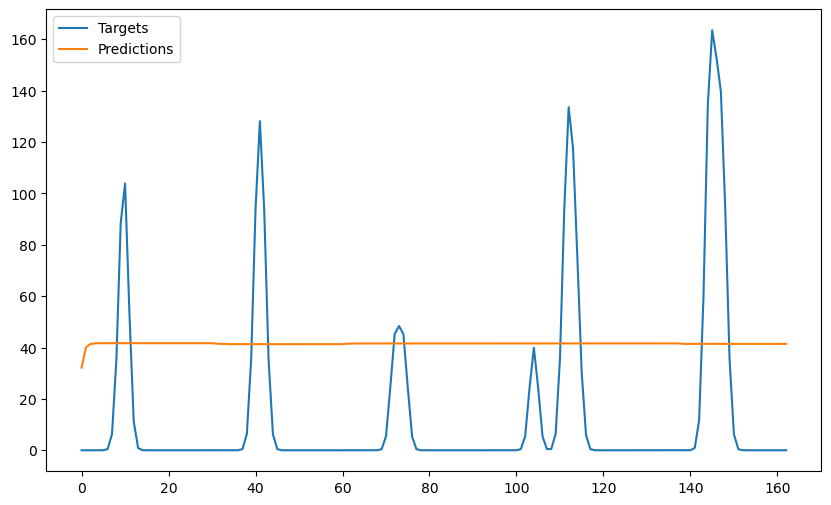

In [161]:
predictions = predictions.flatten()

# plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(targets, label='Targets')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

# Analysis of sample images #

In [42]:
# take random True indices from the mask
np.random.seed(42)
mask = y_masked > 80
indices_high = np.random.choice(np.where(mask)[0], 5)
# take the corresponding images and responses
images_high = x_masked[indices_high]
responses_high = y_masked[indices_high]

mask = y_masked == 0
indices_low = np.random.choice(np.where(mask)[0], 5)
# take the corresponding images and responses
images_low = x_masked[indices_low]
responses_low = y_masked[indices_low]

In [40]:
indices_low

array([34,  2, 32, 87,  1])

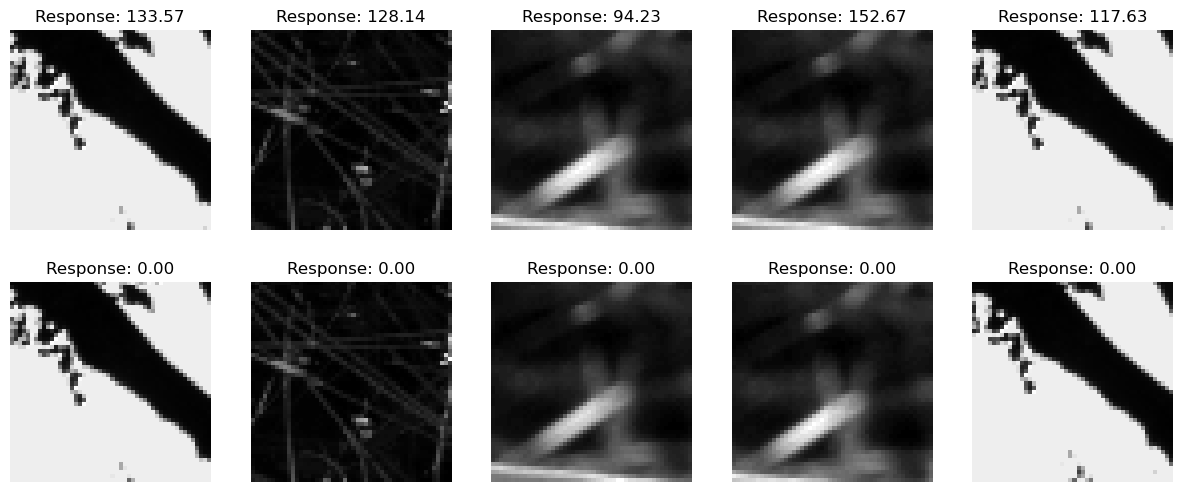

In [43]:
# plot in one row high images and responses
plt.figure(figsize=(15, 6))
for i, (img, resp) in enumerate(zip(images_high, responses_high)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Response: {resp:.2f}')

# plot in one row low images and responses
for i, (img, resp) in enumerate(zip(images_low, responses_low)):
    plt.subplot(2, 5, i+6)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Response: {resp:.2f}')

plt.show()